# UNet 실습

![UNet](https://drive.google.com/uc?export=view&id=1scmhSKYgyHC70_1caI_QsYUMFgMTAg9s)

In [2]:
import os
import sys
print(os.getcwd())
!ls

/content
sample_data


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

import albumentations as A
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torchvision.transforms.functional import to_tensor
from torchvision.utils import save_image

# VOC dataset

In [ ]:
from google.colab import drive
drive.mount('./MyDrive')

In [ ]:
!tar -xvf "./MyDrive/MyDrive/Colab Notebooks/data/VOCtrainval_06-Nov-2007.tar" ## 경로 알맞게 수정

In [ ]:
# For download pascal voc 2007 dataset
from torchvision.datasets import VOCSegmentation
project_path = './'
VOCSegmentation(root=os.path.join(project_path, 'data'), year='2007', download=False)

Dataset VOCSegmentation
    Number of datapoints: 209
    Root location: ./MyDrive/MyDrive/Segmentation_SKT/data

In [ ]:
class DatasetFromFolderVOC(Dataset):
    def __init__(self, root_dir=os.path.join(project_path,'data/VOCdevkit/VOC2007'), txt_file='train.txt', transforms=None):
        super(DatasetFromFolderVOC, self).__init__()
        with open(os.path.join(root_dir, 'ImageSets/Segmentation', txt_file), 'r') as f:
            self.filenames = f.readlines()
        self.filenames = [file.strip() for file in self.filenames]
        self.img_path = os.path.join(root_dir, "JPEGImages")
        self.gt_path = os.path.join(root_dir, "SegmentationClass")
        self.transforms = transforms
        self.pallete = Image.open(os.path.join(self.gt_path, f'{self.filenames[0]}.png')).getpalette()

    # getitem 함수는 index에 맞는 data를 반환하는 역할을 합니다.
    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_path, f'{self.filenames[index]}.jpg')).convert('RGB')
        gt = Image.open(os.path.join(self.gt_path, f'{self.filenames[index]}.png'))

        aug = self.transforms(image=np.array(img), mask=np.array(gt))
        img = to_tensor(aug['image'])
        gt = aug['mask']
        gt[gt > 20] = 0
        gt = torch.tensor(gt)

        return img, gt

    # len 함수는 Dataset 전체 개수를 반환합니다.
    def __len__(self):
        return len(self.filenames)


In [ ]:
transform = A.Compose([
    A.Resize(512, 512),
    #A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])

dataset = DatasetFromFolderVOC(transforms=transform)
img, gt = dataset[0]
pallete = dataset.pallete

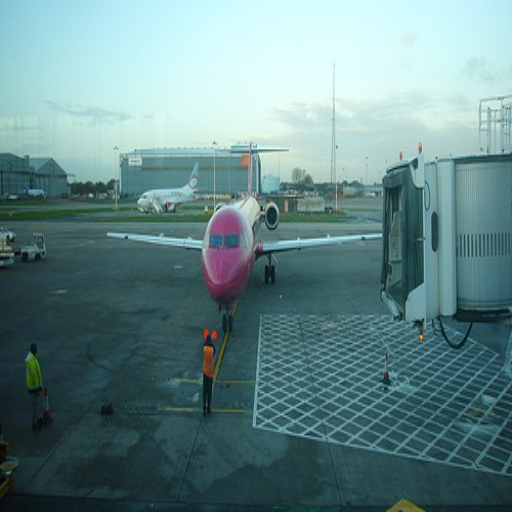

In [ ]:
tf = transforms.ToPILImage()
tf(img)

In [ ]:
gt_img = tf(gt)
gt_img.putpalette(dataset.pallete)

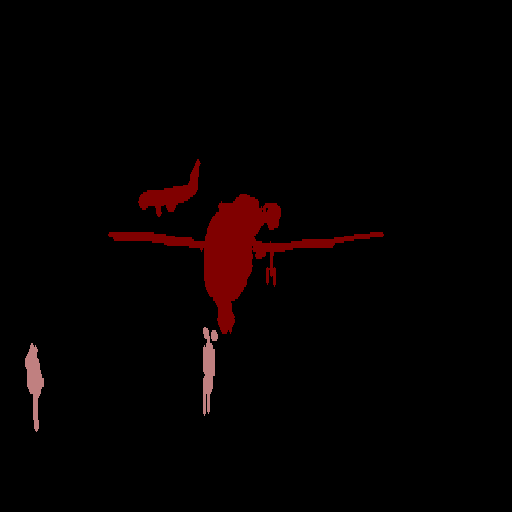

In [ ]:
gt_img

In [ ]:
from torch.utils.data import DataLoader

transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])

train_set = DatasetFromFolderVOC(txt_file='train.txt', transforms=transform)
test_set = DatasetFromFolderVOC(txt_file='val.txt', transforms=transform)

# Training Set과 Test Set을 각각 DataLoader에 넣습니다.
trainDataLoader = DataLoader(dataset=train_set, num_workers=2, batch_size=8, shuffle=True)
testDataLoader = DataLoader(dataset=test_set, num_workers=1, batch_size=1, shuffle=False)

# 여기서부터 실습 시작!

![UNet](https://drive.google.com/uc?export=view&id=1scmhSKYgyHC70_1caI_QsYUMFgMTAg9s)

#### 그림을 참고하여 [Conv, BatchNorm, ReLU] 2개로 구성된 있는 레이어를 구현해 봅시다

In [3]:
class ConvBlock(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels, mid_channels=None): # 주의 : ??? 안에는 왼쪽의 parameter 가 모두 사용됩니다.
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(????????, ?????????, kernel_size= ?????????, padding=????????),
            nn.BatchNorm2d(???????????),
            nn.ReLU(),
            nn.Conv2d(????????, ??????????, kernel_size=?????????, padding=????????),
            nn.BatchNorm2d(???????????),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.double_conv(x)
        return x


#### 그림을 참고하여 [Downsampling, ConvBlock] 으로 구성된 레이어를 구현해 봅시다

In [4]:
class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(???????),
            ConvBlock(??????, ????????)
        )

    def forward(self, x):
        x = self.maxpool_conv(x)
        return x

#### 그림을 참고하여 [Upsampling, ConvBlock] 으로 구성된 레이어를 구현해 봅시다

In [5]:
class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode='bilinear')
        self.conv = ConvBlock(????????, ?????????, ?????????)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x

In [6]:
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(???????????, ?????????, kernel_size=1)

    def forward(self, x):
        x = self.conv(x)
        return x

![UNet](https://drive.google.com/uc?export=view&id=1scmhSKYgyHC70_1caI_QsYUMFgMTAg9s)

In [7]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inc = ConvBlock(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)
        self.up1 = Up(1024, 256)
        self.up2 = Up(512, 128)
        self.up3 = Up(256, 64)
        self.up4 = Up(128, 64)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [8]:
num_classes = 21  # 20 + background
model = UNet(3, num_classes)

input = torch.zeros((1,3,512,512))
output = model(input)
print(input.shape, output.shape) # torch.Size([1, 3, 512, 512]) torch.Size([1, 21, 512, 512])

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


torch.Size([1, 3, 512, 512]) torch.Size([1, 21, 512, 512])


# Train

In [ ]:
import torch.optim as optim
from tqdm import tqdm



model = model.cuda().train()
criterion = nn.CrossEntropyLoss()
# setup optimizer
# optimizer = optim.SGD(model.parameters(), lr=1e-5, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=1e-5, betas=(0.9, 0.999))

total_epoch = 1

# Training
for epoch in range(total_epoch):
    for i, (img, gt) in enumerate(trainDataLoader):
        img = img.cuda()
        gt = gt.long().cuda()

        # forward and calculate the loss
        pred = model(img)
        loss = criterion(pred, gt)

        # Backprop + Optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i % 10 == 0:        
            print(f'[{epoch+1}][{i+1}/{len(trainDataLoader)}] Loss: {loss.item():.3f}')


In [ ]:
# Visualization
model.eval()
num_imgs = 4
preds_train, gts_train = None, None
preds_val, gts_val = None, None
for i, (img, gt) in enumerate(trainDataLoader):
    if i * trainDataLoader.batch_size >= num_imgs:
        break
    with torch.no_grad():
        # forward
        img = img.cuda()
        gt = gt.long().cuda()
        pred = model(img)
        output_pred = pred.argmax(1)
        for j in range(min(trainDataLoader.batch_size, 4)):
            out_img = Image.fromarray(np.array(output_pred[j].cpu()).astype('uint8'))
            out_img.putpalette(train_set.pallete)
            out_img = to_tensor(out_img.convert('RGB')).unsqueeze(0)
            preds_train = out_img if i == 0 and j == 0 else torch.cat([preds_train, out_img])
            out_img = Image.fromarray(np.array(gt[j].cpu()).astype('uint8'))
            out_img.putpalette(train_set.pallete)
            out_img = to_tensor(out_img.convert('RGB')).unsqueeze(0)
            gts_train = out_img if i == 0 and j == 0 else torch.cat([gts_train, out_img])
            
for i, (img, gt) in enumerate(testDataLoader):
    if i * testDataLoader.batch_size >= num_imgs:
        break
    with torch.no_grad():
        # forward
        img = img.cuda()
        gt = gt.long().cuda()
        pred = model(img)
        output_pred = pred.argmax(1)
        for j in range(min(testDataLoader.batch_size, num_imgs)):
            out_img = Image.fromarray(np.array(output_pred[j].cpu()).astype('uint8'))
            out_img.putpalette(test_set.pallete)
            out_img = to_tensor(out_img.convert('RGB')).unsqueeze(0)
            preds_test = out_img if i == 0 and j == 0 else torch.cat([preds_test, out_img])
            out_img = Image.fromarray(np.array(gt[j].cpu()).astype('uint8'))
            out_img.putpalette(test_set.pallete)
            out_img = to_tensor(out_img.convert('RGB')).unsqueeze(0)
            gts_test = out_img if i == 0 and j == 0 else torch.cat([gts_test, out_img])

train_samples = torch.cat([preds_train.cpu(), gts_train])
train_samples = torchvision.utils.make_grid(train_samples, nrow=num_imgs)
train_samples = train_samples.permute(1, 2, 0)

test_samples = torch.cat([preds_test.cpu(), gts_test])
test_samples = torchvision.utils.make_grid(test_samples, nrow=num_imgs)
test_samples = test_samples.permute(1, 2, 0)

plt.rcParams["figure.figsize"] = (30, 15)
plt.subplot(2, 1, 1)
plt.imshow(train_samples)
plt.subplot(2, 1, 2)
plt.imshow(test_samples)

# Inference using pretrained model

In [9]:
from torchvision import models
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T
import numpy as np

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth


  0%|          | 0.00/161M [00:00<?, ?B/s]

2021-12-26 20:06:29 URL:https://static.independent.co.uk/s3fs-public/thumbnails/image/2018/04/10/19/pinyon-jay-bird.jpg [182965/182965] -> "bird.png" [1]


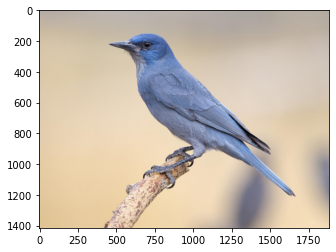

torch.Size([1, 21, 224, 224])
(224, 224)
[0 3]


In [10]:
deeplabv3 = models.segmentation.deeplabv3_resnet50(pretrained=True).eval()


!wget -nv https://static.independent.co.uk/s3fs-public/thumbnails/image/2018/04/10/19/pinyon-jay-bird.jpg -O bird.png
img = Image.open('./bird.png')
plt.imshow(img); plt.show()

trf = T.Compose([T.Resize(256),
                 T.CenterCrop(224),
                 T.ToTensor(), 
                 T.Normalize(mean = [0.485, 0.456, 0.406], 
                             std = [0.229, 0.224, 0.225])])
inp = trf(img).unsqueeze(0)
# Pass the input through the net
out = deeplabv3(inp)['out']
print (out.shape)

om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
print (om.shape)
print (np.unique(om))

In [11]:
def decode_segmap(image, nc=21):
  
  label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  
  for l in range(0, nc):
    idx = image == l
    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[l, 1]
    b[idx] = label_colors[l, 2]
    
  rgb = np.stack([r, g, b], axis=2)
  return rgb

In [12]:
def segment(net, path, show_orig=True, dev='cuda'):
  img = Image.open(path)
  if show_orig: plt.imshow(img); plt.axis('off'); plt.show()
  # Comment the Resize and CenterCrop for better inference results
  trf = T.Compose([T.Resize(640), 
                   #T.CenterCrop(224), 
                   T.ToTensor(), 
                   T.Normalize(mean = [0.485, 0.456, 0.406], 
                               std = [0.229, 0.224, 0.225])])
  inp = trf(img).unsqueeze(0).to(dev)
  out = net.to(dev)(inp)['out']
  om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
  rgb = decode_segmap(om)
  plt.imshow(rgb); plt.axis('off'); plt.show()

2021-12-26 20:06:53 URL:https://www.learnopencv.com/wp-content/uploads/2021/01/horse-segmentation.jpeg [434252/434252] -> "horse.png" [1]


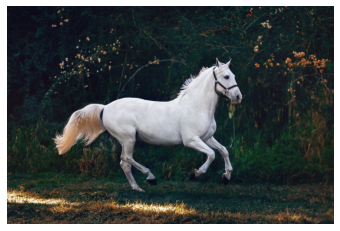

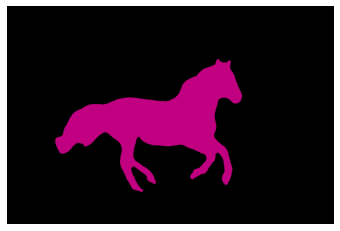

In [13]:
!wget -nv https://www.learnopencv.com/wp-content/uploads/2021/01/horse-segmentation.jpeg -O horse.png
segment(deeplabv3, './horse.png')

2021-12-26 20:07:16 URL:https://www.learnopencv.com/wp-content/uploads/2021/01/person-segmentation.jpeg [422242/422242] -> "person.png" [1]
Segmenatation Image on DeepLabv3


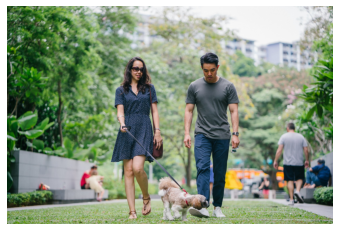

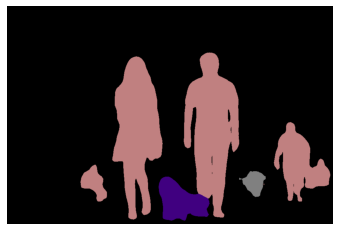

In [14]:
!wget -nv "https://www.learnopencv.com/wp-content/uploads/2021/01/person-segmentation.jpeg" -O person.png
img = Image.open('./person.png')
print ('Segmenatation Image on DeepLabv3')
segment(deeplabv3, path='./person.png', show_orig=True)